In [397]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Pendulum: Writing your environment and transforms with TorchRL
==============================================================

**Author**: [Vincent Moens](https://github.com/vmoens)

Creating an environment (a simulator or an interface to a physical
control system) is an integrative part of reinforcement learning and
control engineering.

TorchRL provides a set of tools to do this in multiple contexts. This
tutorial demonstrates how to use PyTorch and TorchRL code a pendulum
simulator from the ground up. It is freely inspired by the Pendulum-v1
implementation from [OpenAI-Gym/Farama-Gymnasium control
library](https://github.com/Farama-Foundation/Gymnasium).

![Simple
Pendulum](https://pytorch.org/tutorials/_static/img/pendulum.gif){.align-center}

Key learnings:

-   How to design an environment in TorchRL:

    -   Writing specs (input, observation and reward);
    -   Implementing behavior: seeding, reset and step.

-   Transforming your environment inputs and outputs, and writing your
    own transforms;

-   How to use `~tensordict.TensorDict`{.interpreted-text role="class"}
    to carry arbitrary data structures through the `codebase`.

    In the process, we will touch three crucial components of TorchRL:

-   [environments](https://pytorch.org/rl/stable/reference/envs.html)

-   [transforms](https://pytorch.org/rl/stable/reference/envs.html#transforms)

-   [models (policy and value
    function)](https://pytorch.org/rl/stable/reference/modules.html)


To give a sense of what can be achieved with TorchRL\'s environments, we
will be designing a *stateless* environment. While stateful environments
keep track of the latest physical state encountered and rely on this to
simulate the state-to-state transition, stateless environments expect
the current state to be provided to them at each step, along with the
action undertaken. TorchRL supports both types of environments, but
stateless environments are more generic and hence cover a broader range
of features of the environment API in TorchRL.

Modeling stateless environments gives users full control over the input
and outputs of the simulator: one can reset an experiment at any stage
or actively modify the dynamics from the outside. However, it assumes
that we have some control over a task, which may not always be the case:
solving a problem where we cannot control the current state is more
challenging but has a much wider set of applications.

Another advantage of stateless environments is that they can enable
batched execution of transition simulations. If the backend and the
implementation allow it, an algebraic operation can be executed
seamlessly on scalars, vectors, or tensors. This tutorial gives such
examples.

This tutorial will be structured as follows:

-   We will first get acquainted with the environment properties: its
    shape (`batch_size`), its methods (mainly
    `~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"},
    `~torchrl.envs.EnvBase.reset`{.interpreted-text role="meth"} and
    `~torchrl.envs.EnvBase.set_seed`{.interpreted-text role="meth"}) and
    finally its specs.
-   After having coded our simulator, we will demonstrate how it can be
    used during training with transforms.
-   We will explore new avenues that follow from the TorchRL\'s API,
    including: the possibility of transforming inputs, the vectorized
    execution of the simulation and the possibility of backpropagation
    through the simulation graph.
-   Finally, we will train a simple policy to solve the system we
    implemented.


In [398]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

DEFAULT_X = np.pi
DEFAULT_Y = 1.0

There are four things you must take care of when designing a new
environment class:

-   `EnvBase._reset`{.interpreted-text role="meth"}, which codes for the
    resetting of the simulator at a (potentially random) initial state;
-   `EnvBase._step`{.interpreted-text role="meth"} which codes for the
    state transition dynamic;
-   `EnvBase._set_seed`{.interpreted-text role="meth"}\` which
    implements the seeding mechanism;
-   the environment specs.

Let us first describe the problem at hand: we would like to model a
simple pendulum over which we can control the torque applied on its
fixed point. Our goal is to place the pendulum in upward position
(angular position at 0 by convention) and having it standing still in
that position. To design our dynamic system, we need to define two
equations: the motion equation following an action (the torque applied)
and the reward equation that will constitute our objective function.

For the motion equation, we will update the angular velocity following:

$$\dot{\theta}_{t+1} = \dot{\theta}_t + (3 * g / (2 * L) * \sin(\theta_t) + 3 / (m * L^2) * u) * dt$$

where $\dot{\theta}$ is the angular velocity in rad/sec, $g$ is the
gravitational force, $L$ is the pendulum length, $m$ is its mass,
$\theta$ is its angular position and $u$ is the torque. The angular
position is then updated according to

$$\theta_{t+1} = \theta_{t} + \dot{\theta}_{t+1} dt$$

We define our reward as

$$r = -(\theta^2 + 0.1 * \dot{\theta}^2 + 0.001 * u^2)$$

which will be maximized when the angle is close to 0 (pendulum in upward
position), the angular velocity is close to 0 (no motion) and the torque
is 0 too.

Coding the effect of an action: `~torchrl.envs.EnvBase._step`{.interpreted-text role="func"}
============================================================================================

The step method is the first thing to consider, as it will encode the
simulation that is of interest to us. In TorchRL, the
`~torchrl.envs.EnvBase`{.interpreted-text role="class"} class has a
`EnvBase.step`{.interpreted-text role="meth"} method that receives a
`tensordict.TensorDict`{.interpreted-text role="class"} instance with an
`"action"` entry indicating what action is to be taken.

To facilitate the reading and writing from that `tensordict` and to make
sure that the keys are consistent with what\'s expected from the
library, the simulation part has been delegated to a private abstract
method `_step`{.interpreted-text role="meth"} which reads input data
from a `tensordict`, and writes a *new* `tensordict` with the output
data.

The `_step`{.interpreted-text role="func"} method should do the
following:

> 1.  Read the input keys (such as `"action"`) and execute the
>     simulation based on these;
> 2.  Retrieve observations, done state and reward;
> 3.  Write the set of observation values along with the reward and done
>     state at the corresponding entries in a new
>     `TensorDict`{.interpreted-text role="class"}.

Next, the `~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"}
method will merge the output of
`~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"} in the input
`tensordict` to enforce input/output consistency.

Typically, for stateful environments, this will look like this:

``` {.}
>>> policy(env.reset())
>>> print(tensordict)
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
>>> env.step(tensordict)
>>> print(tensordict)
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
```

Notice that the root `tensordict` has not changed, the only modification
is the appearance of a new `"next"` entry that contains the new
information.

In the Pendulum example, our `_step`{.interpreted-text role="meth"}
method will read the relevant entries from the input `tensordict` and
compute the position and velocity of the pendulum after the force
encoded by the `"action"` key has been applied onto it. We compute the
new angular position of the pendulum `"new_th"` as the result of the
previous position `"th"` plus the new velocity `"new_thdot"` over a time
interval `dt`.

Since our goal is to turn the pendulum up and maintain it still in that
position, our `cost` (negative reward) function is lower for positions
close to the target and low speeds. Indeed, we want to discourage
positions that are far from being \"upward\" and/or speeds that are far
from 0.

In our example, `EnvBase._step`{.interpreted-text role="meth"} is
encoded as a static method since our environment is stateless. In
stateful settings, the `self` argument is needed as the state needs to
be read from the environment.


In [399]:
def _step(tensordict):
    th, thdot = tensordict["th"], tensordict["thdot"]  # th := theta

    g_force = tensordict["params", "g"]
    mass = tensordict["params", "m"]
    length = tensordict["params", "l"]
    dt = tensordict["params", "dt"]
    u = tensordict["action"].squeeze(-1)
    u = u.clamp(-tensordict["params", "max_torque"], tensordict["params", "max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)

    new_thdot = (
        thdot
        + (3 * g_force / (2 * length) * th.sin() + 3.0 / (mass * length**2) * u) * dt
    )
    new_thdot = new_thdot.clamp(
        -tensordict["params", "max_speed"], tensordict["params", "max_speed"]
    )
    new_th = th + new_thdot * dt
    reward = -costs.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "th": new_th,
            "thdot": new_thdot,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )
    return out


def angle_normalize(x):
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

Resetting the simulator: `~torchrl.envs.EnvBase._reset`{.interpreted-text role="func"}
======================================================================================

The second method we need to care about is the
`~torchrl.envs.EnvBase._reset`{.interpreted-text role="meth"} method.
Like `~torchrl.envs.EnvBase._step`{.interpreted-text role="meth"}, it
should write the observation entries and possibly a done state in the
`tensordict` it outputs (if the done state is omitted, it will be filled
as `False` by the parent method
`~torchrl.envs.EnvBase.reset`{.interpreted-text role="meth"}). In some
contexts, it is required that the `_reset` method receives a command
from the function that called it (for example, in multi-agent settings
we may want to indicate which agents need to be reset). This is why the
`~torchrl.envs.EnvBase._reset`{.interpreted-text role="meth"} method
also expects a `tensordict` as input, albeit it may perfectly be empty
or `None`.

The parent `EnvBase.reset`{.interpreted-text role="meth"} does some
simple checks like the `EnvBase.step`{.interpreted-text role="meth"}
does, such as making sure that a `"done"` state is returned in the
output `tensordict` and that the shapes match what is expected from the
specs.

For us, the only important thing to consider is whether
`EnvBase._reset`{.interpreted-text role="meth"} contains all the
expected observations. Once more, since we are working with a stateless
environment, we pass the configuration of the pendulum in a nested
`tensordict` named `"params"`.

In this example, we do not pass a done state as this is not mandatory
for `_reset`{.interpreted-text role="meth"} and our environment is
non-terminating, so we always expect it to be `False`.


In [400]:
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)

    high_th = torch.tensor(DEFAULT_X, device=self.device)
    high_thdot = torch.tensor(DEFAULT_Y, device=self.device)
    low_th = -high_th
    low_thdot = -high_thdot

    # for non batch-locked environments, the input ``tensordict`` shape dictates the number
    # of simulators run simultaneously. In other contexts, the initial
    # random state's shape will depend upon the environment batch-size instead.
    th = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_th - low_th)
        + low_th
    )
    thdot = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_thdot - low_thdot)
        + low_thdot
    )
    out = TensorDict(
        {
            "th": th,
            "thdot": thdot,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

Environment metadata: `env.*_spec`
==================================

The specs define the input and output domain of the environment. It is
important that the specs accurately define the tensors that will be
received at runtime, as they are often used to carry information about
environments in multiprocessing and distributed settings. They can also
be used to instantiate lazily defined neural networks and test scripts
without actually querying the environment (which can be costly with
real-world physical systems for instance).

There are four specs that we must code in our environment:

-   `EnvBase.observation_spec`{.interpreted-text role="obj"}: This will
    be a `~torchrl.data.CompositeSpec`{.interpreted-text role="class"}
    instance where each key is an observation (a
    `CompositeSpec`{.interpreted-text role="class"} can be viewed as a
    dictionary of specs).
-   `EnvBase.action_spec`{.interpreted-text role="obj"}: It can be any
    type of spec, but it is required that it corresponds to the
    `"action"` entry in the input `tensordict`;
-   `EnvBase.reward_spec`{.interpreted-text role="obj"}: provides
    information about the reward space;
-   `EnvBase.done_spec`{.interpreted-text role="obj"}: provides
    information about the space of the done flag.

TorchRL specs are organized in two general containers: `input_spec`
which contains the specs of the information that the step function reads
(divided between `action_spec` containing the action and `state_spec`
containing all the rest), and `output_spec` which encodes the specs that
the step outputs (`observation_spec`, `reward_spec` and `done_spec`). In
general, you should not interact directly with `output_spec` and
`input_spec` but only with their content: `observation_spec`,
`reward_spec`, `done_spec`, `action_spec` and `state_spec`. The reason
if that the specs are organized in a non-trivial way within
`output_spec` and `input_spec` and neither of these should be directly
modified.

In other words, the `observation_spec` and related properties are
convenient shortcuts to the content of the output and input spec
containers.

TorchRL offers multiple `~torchrl.data.TensorSpec`{.interpreted-text
role="class"}
[subclasses](https://pytorch.org/rl/stable/reference/data.html#tensorspec)
to encode the environment\'s input and output characteristics.

Specs shape
-----------

The environment specs leading dimensions must match the environment
batch-size. This is done to enforce that every component of an
environment (including its transforms) have an accurate representation
of the expected input and output shapes. This is something that should
be accurately coded in stateful settings.

For non batch-locked environments, such as the one in our example (see
below), this is irrelevant as the environment batch size will most
likely be empty.


In [401]:
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        th=BoundedTensorSpec(
            low=-torch.pi,
            high=torch.pi,
            shape=(),
            dtype=torch.float32,
        ),
        thdot=BoundedTensorSpec(
            low=-td_params["params", "max_speed"],
            high=td_params["params", "max_speed"],
            shape=(),
            dtype=torch.float32,
        ),
        # we need to add the ``params`` to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, ``EnvBase`` expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    self.action_spec = BoundedTensorSpec(
        low=-td_params["params", "max_torque"],
        high=td_params["params", "max_torque"],
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

Reproducible experiments: seeding
=================================

Seeding an environment is a common operation when initializing an
experiment. The only goal of `EnvBase._set_seed`{.interpreted-text
role="func"} is to set the seed of the contained simulator. If possible,
this operation should not call `reset()` or interact with the
environment execution. The parent `EnvBase.set_seed`{.interpreted-text
role="func"} method incorporates a mechanism that allows seeding
multiple environments with a different pseudo-random and reproducible
seed.


In [402]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

Wrapping things together: the `~torchrl.envs.EnvBase`{.interpreted-text role="class"} class
===========================================================================================

We can finally put together the pieces and design our environment class.
The specs initialization needs to be performed during the environment
construction, so we must take care of calling the
`_make_spec`{.interpreted-text role="func"} method within
`PendulumEnv.__init__`{.interpreted-text role="func"}.

We add a static method `PendulumEnv.gen_params`{.interpreted-text
role="meth"} which deterministically generates a set of hyperparameters
to be used during execution:


In [403]:
def gen_params(g=10.0, batch_size=None) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_speed": 8,
                    "max_torque": 2.0,
                    "dt": 0.05,
                    "g": g,
                    "m": 1.0,
                    "l": 1.0,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

We define the environment as non-`batch_locked` by turning the
`homonymous` attribute to `False`. This means that we will **not**
enforce the input `tensordict` to have a `batch-size` that matches the
one of the environment.

The following code will just put together the pieces we have coded
above.


In [404]:
class PendulumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

Testing our environment
=======================

TorchRL provides a simple function
`~torchrl.envs.utils.check_env_specs`{.interpreted-text role="func"} to
check that a (transformed) environment has an input/output structure
that matches the one dictated by its specs. Let us try it out:


In [405]:
env = PendulumEnv()
check_env_specs(env)

2025-03-12 22:19:55,363 [torchrl][INFO] check_env_specs succeeded!


We can have a look at our specs to have a visual representation of the
environment signature:


In [406]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: Composite(
    th: BoundedContinuous(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thdot: BoundedContinuous(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: Composite(
        max_speed: UnboundedDiscrete(
            shape=torch.Size([]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True),
                high=Tensor(

We can execute a couple of commands too to check that the output
structure matches what is expected.


In [407]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        th: Te

We can run the `env.rand_step`{.interpreted-text role="func"} to
generate an action randomly from the `action_spec` domain. A
`tensordict` containing the hyperparameters and the current state
**must** be passed since our environment is stateless. In stateful
contexts, `env.rand_step()` works perfectly too.


In [408]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
         

Transforming an environment
===========================

Writing environment transforms for stateless simulators is slightly more
complicated than for stateful ones: transforming an output entry that
needs to be read at the following iteration requires to apply the
inverse transform before calling `meth.step`{.interpreted-text
role="func"} at the next step. This is an ideal scenario to showcase all
the features of TorchRL\'s transforms!

For instance, in the following transformed environment we `unsqueeze`
the entries `["th", "thdot"]` to be able to stack them along the last
dimension. We also pass them as `in_keys_inv` to squeeze them back to
their original shape once they are passed as input in the next
iteration.


In [409]:
env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

Writing custom transforms
=========================

TorchRL\'s transforms may not cover all the operations one wants to
execute after an environment has been executed. Writing a transform does
not require much effort. As for the environment design, there are two
steps in writing a transform:

-   Getting the dynamics right (forward and inverse);
-   Adapting the environment specs.

A transform can be used in two settings: on its own, it can be used as a
`~torch.nn.Module`{.interpreted-text role="class"}. It can also be used
appended to a
`~torchrl.envs.transforms.TransformedEnv`{.interpreted-text
role="class"}. The structure of the class allows to customize the
behavior in the different contexts.

A `~torchrl.envs.transforms.Transform`{.interpreted-text role="class"}
skeleton can be summarized as follows:

``` {.}
class Transform(nn.Module):
    def forward(self, tensordict):
        ...
    def _apply_transform(self, tensordict):
        ...
    def _step(self, tensordict):
        ...
    def _call(self, tensordict):
        ...
    def inv(self, tensordict):
        ...
    def _inv_apply_transform(self, tensordict):
        ...
```

There are three entry points (`forward`{.interpreted-text role="func"},
`_step`{.interpreted-text role="func"} and `inv`{.interpreted-text
role="func"}) which all receive
`tensordict.TensorDict`{.interpreted-text role="class"} instances. The
first two will eventually go through the keys indicated by
`~tochrl.envs.transforms.Transform.in_keys`{.interpreted-text
role="obj"} and call
`~torchrl.envs.transforms.Transform._apply_transform`{.interpreted-text
role="meth"} to each of these. The results will be written in the
entries pointed by `Transform.out_keys`{.interpreted-text role="obj"} if
provided (if not the `in_keys` will be updated with the transformed
values). If inverse transforms need to be executed, a similar data flow
will be executed but with the `Transform.inv`{.interpreted-text
role="func"} and `Transform._inv_apply_transform`{.interpreted-text
role="func"} methods and across the `in_keys_inv` and `out_keys_inv`
list of keys. The following figure summarized this flow for environments
and replay buffers.

> Transform API

In some cases, a transform will not work on a subset of keys in a
unitary manner, but will execute some operation on the parent
environment or work with the entire input `tensordict`. In those cases,
the `_call`{.interpreted-text role="func"} and
`forward`{.interpreted-text role="func"} methods should be re-written,
and the `_apply_transform`{.interpreted-text role="func"} method can be
skipped.

Let us code new transforms that will compute the `sine` and `cosine`
values of the position angle, as these values are more useful to us to
learn a policy than the raw angle value:


In [410]:
class SinTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.sin()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


class CosTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.cos()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)

TransformedEnv(
    env=PendulumEnv(),
    transform=Compose(
            UnsqueezeTransform(dim=-1, in_keys=['th', 'thdot'], out_keys=['th', 'thdot'], in_keys_inv=['th', 'thdot'], out_keys_inv=['th', 'thdot']),
            SinTransform(keys=['th']),
            CosTransform(keys=['th'])))

Concatenates the observations onto an \"observation\" entry.
`del_keys=False` ensures that we keep these values for the next
iteration.


In [411]:
cat_transform = CatTensors(
    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)

TransformedEnv(
    env=PendulumEnv(),
    transform=Compose(
            UnsqueezeTransform(dim=-1, in_keys=['th', 'thdot'], out_keys=['th', 'thdot'], in_keys_inv=['th', 'thdot'], out_keys_inv=['th', 'thdot']),
            SinTransform(keys=['th']),
            CosTransform(keys=['th']),
            CatTensors(in_keys=['cos', 'sin', 'thdot'], out_key=observation)))

Once more, let us check that our environment specs match what is
received:


In [412]:
check_env_specs(env)

2025-03-12 22:19:55,647 [torchrl][INFO] check_env_specs succeeded!


Executing a rollout
===================

Executing a rollout is a succession of simple steps:

-   reset the environment
-   while some condition is not met:
    -   compute an action given a policy
    -   execute a step given this action
    -   collect the data
    -   make a `MDP` step
-   gather the data and return

These operations have been conveniently wrapped in the
`~torchrl.envs.EnvBase.rollout`{.interpreted-text role="meth"} method,
from which we provide a simplified version here below.


In [413]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False)

Batching computations
=====================

The last unexplored end of our tutorial is the ability that we have to
batch computations in TorchRL. Because our environment does not make any
assumptions regarding the input data shape, we can seamlessly execute it
over batches of data. Even better: for non-batch-locked environments
such as our Pendulum, we can change the batch size on the fly without
recreating the environment. To do this, we just generate parameters with
the desired shape.


In [414]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        cos: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float3

Executing a rollout with a batch of data requires us to reset the
environment out of the rollout function, since we need to define the
batch\_size dynamically and this is not supported by
`~torchrl.envs.EnvBase.rollout`{.interpreted-text role="meth"}:


In [415]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([10, 3]), device=cpu, dty

Training a simple policy
========================

In this example, we will train a simple policy using the reward as a
differentiable objective, such as a negative loss. We will take
advantage of the fact that our dynamic system is fully differentiable to
backpropagate through the trajectory return and adjust the weights of
our policy to maximize this value directly. Of course, in many settings
many of the assumptions we make do not hold, such as differentiable
system and full access to the underlying mechanics.

Still, this is a very simple example that showcases how a training loop
can be coded with a custom environment in TorchRL.

Let us first write the policy network:


In [416]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

and our optimizer:


In [417]:
optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

Training loop
=============

We will successively:

-   generate a trajectory
-   sum the rewards
-   backpropagate through the graph defined by these operations
-   clip the gradient norm and make an optimization step
-   repeat

At the end of the training loop, we should have a final reward close to
0 which demonstrates that the pendulum is upward and still as desired.


reward: -2.0713, last reward: -0.0030, gradient norm:  0.5118: 100%|██████████| 156/156 [00:34<00:00,  4.47it/s]


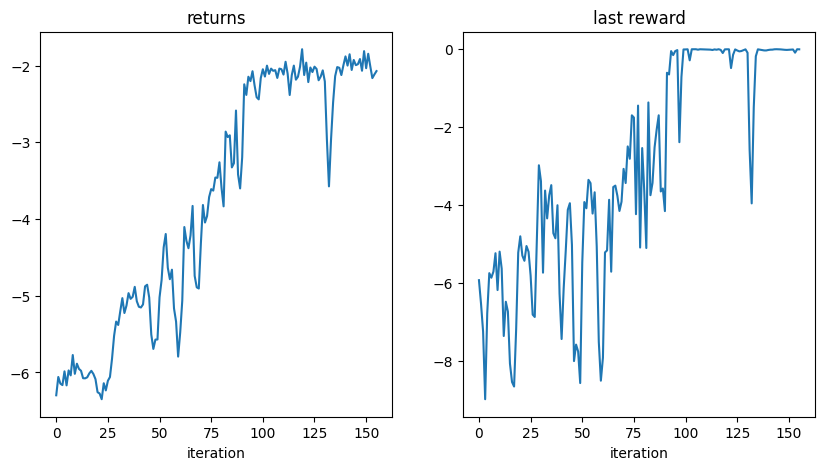

In [418]:
batch_size = 128
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(logs["return"])
    plt.title("returns")
    plt.xlabel("iteration")
    plt.subplot(1, 2, 2)
    plt.plot(logs["last_reward"])
    plt.title("last reward")
    plt.xlabel("iteration")
    plt.show()


plot()

Conclusion
==========

In this tutorial, we have learned how to code a stateless environment
from scratch. We touched the subjects of:

-   The four essential components that need to be taken care of when
    coding an environment (`step`, `reset`, seeding and building specs).
    We saw how these methods and classes interact with the
    `~tensordict.TensorDict`{.interpreted-text role="class"} class;
-   How to test that an environment is properly coded using
    `~torchrl.envs.utils.check_env_specs`{.interpreted-text
    role="func"};
-   How to append transforms in the context of stateless environments
    and how to write custom transformations;
-   How to train a policy on a fully differentiable simulator.


In [419]:
import gymnasium as gym
import cv2

# After training, visualize the trained policy
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
observation, info = env.reset()

# Use the same device as your network for consistency
device = next(net.parameters()).device

for _ in range(1000):
    # Convert observation to tensor and move to device
    obs_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
    with torch.no_grad():
        action_tensor = net(obs_tensor)  # Get action from trained network
    
    # Convert action to numpy array and remove batch dimension
    action = action_tensor.squeeze(0).cpu().numpy()
    
    # Step the environment
    observation, reward, terminated, truncated, info = env.step(action)
    
    # Render
    frame = env.render()
    cv2.imshow("Trained Pendulum", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
    if terminated or truncated:
        observation, info = env.reset()

env.close()
cv2.destroyAllWindows()
